In [1]:
import numpy as np

def speed_of_sound(temperature_celsius):
  """
  Calculates the speed of sound in dry air based on temperature.
  A simple approximation is used here, neglecting humidity effects for simplicity.
  For a more accurate calculation including humidity, more complex formulas are needed.

  Args:
    temperature_celsius: Temperature in degrees Celsius.
    relative_humidity: Relative humidity as a percentage (0-100).

  Returns:
    The speed of sound in meters per second.
  """
  # This is a simplified formula for dry air.
  # A more accurate formula would involve vapor pressure related to humidity.
  return 331.3 + 0.606 * temperature_celsius

# Note: This function provides a good approximation for typical conditions.
# For highly precise calculations or extreme conditions, consider more complex models.

In [9]:
from typing_extensions import final
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import os
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm # Import colormap


def locate_emitter(receiver_locations, detection_times, speed_of_sound_mps, plot_counter=0, actual_location=None):
    """
    Estimates the location of a signal emitter in 3D space using TDOA by
    performing a grid search with parallel processing and saves a 2D slice
    of the error grid and a 3D scatter plot/heatmap.

    Args:
      receiver_locations: A list of tuples or arrays representing the (x, y, z)
                          coordinates of the receivers.
      detection_times: A list or array of the signal detection times at each
                       receiver.
      speed_of_sound_mps: The speed of sound in meters per second.
      plot_counter: A counter to generate unique filenames for saved plots.
      actual_location: The actual (x, y, z) coordinates of the emitter (optional).

    Returns:
      A tuple representing the estimated (x, y, z) coordinates of the emitter
      with the lowest error.
    """
    # Convert receiver_locations to a NumPy array for easier calculations
    receiver_locations = np.array(receiver_locations)

    def calculate_error(emitter_location, receiver_locations, detection_times, speed_of_sound_mps):
        """Calculates the sum of squared errors for a given emitter location in 3D."""
        x, y, z = emitter_location
        errors = []
        for i in range(len(receiver_locations)):
            receiver_x, receiver_y, receiver_z = receiver_locations[i]
            # Calculate the distance from the potential emitter location to the receiver in 3D
            distance = np.sqrt((x - receiver_x)**2 + (y - receiver_y)**2 + (z - receiver_z)**2)
            # Calculate the expected arrival time difference based on distance
            expected_time_diffs = [(np.sqrt((x - rx)**2 + (y - ry)**2 + (z - rz)**2) - distance) / speed_of_sound_mps
                                   for rx, ry, rz in receiver_locations]
            # Calculate the actual arrival time differences
            actual_time_diffs = [(dt - detection_times[i]) for dt in detection_times]

            # The error is the difference between expected and actual time differences
            # We can minimize the sum of squared errors of the actual and expected time differences
            for j in range(len(actual_time_diffs)):
                errors.append((actual_time_diffs[j] - expected_time_diffs[j])**2)

        return np.sum(errors)

    # Define the grid in 3D
    grid_size = 50 # Reduced grid size for 3D grid search
    x_range = np.linspace(-500, 500, grid_size)
    y_range = np.linspace(-500, 500, grid_size)
    z_range = np.linspace(0, 100, grid_size) # Assuming a reasonable range for Z
    error_grid = np.zeros((grid_size, grid_size, grid_size))

    # Parallelized calculation of error for each point on the 3D grid
    coords = [(x, y, z) for z in z_range for y in y_range for x in x_range]

    errors = Parallel(n_jobs=-1)(delayed(calculate_error)(coord, receiver_locations, detection_times, speed_of_sound_mps) for coord in coords)

    # Reshape the errors back into the 3D grid format
    error_grid = np.array(errors).reshape((grid_size, grid_size, grid_size))

    # Find the location with the minimum error in 3D
    min_error_index = np.argmin(error_grid)
    min_error_z, min_error_y, min_error_x = np.unravel_index(min_error_index, error_grid.shape)
    best_emitter_location = (x_range[min_error_x], y_range[min_error_y], z_range[min_error_z])

    # Plotting: Visualize a slice of the 3D error grid (e.g., at the estimated Z) and a 3D scatter plot/heatmap
    estimated_z_index = np.argmin(np.abs(z_range - best_emitter_location[2]))
    error_slice = error_grid[estimated_z_index, :, :]

    plt.figure(figsize=(10, 8))
    plt.imshow(error_slice, extent=[x_range.min(), x_range.max(), y_range.min(), y_range.max()],
               origin='lower', cmap='hot', aspect='auto')
    plt.colorbar(label="Sum of Squared Errors")
    plt.title(f"Error Grid Slice at Estimated Z = {z_range[estimated_z_index]:.2f}m (Plot {plot_counter:03d})")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")

    # Mark the estimated emitter location on the 2D slice
    plt.plot(best_emitter_location[0], best_emitter_location[1], 'wo', markersize=12, label='Estimated Emitter Location (X,Y)')

    # Plot receiver locations on the 2D slice (only X and Y)
    plt.plot(receiver_locations[:, 0], receiver_locations[:, 1], 'go', markersize=8, label='Receiver Locations (X,Y)')

    # Plot actual emitter location if provided on the 2D slice (only X and Y)
    if actual_location is not None:
        plt.plot(actual_location[0], actual_location[1], 'rX', markersize=10, label='Actual Emitter Location (X,Y)')


    plt.legend()

    # Save the 2D slice plot
    output_dir = "emitter_heatmaps"
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, f"heatmap_slice_{plot_counter:03d}.jpg"))

    plt.show()

    # Create a 3D scatter plot of receiver locations, estimated location, and actual location
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot receiver locations in 3D
    ax.scatter(receiver_locations[:, 0], receiver_locations[:, 1], receiver_locations[:, 2], c='g', marker='o', s=50, label='Receiver Locations')

    # Plot estimated emitter location in 3D
    ax.scatter(best_emitter_location[0], best_emitter_location[1], best_emitter_location[2], c='w', marker='o', s=100, label='Estimated Emitter Location')

    # Plot actual emitter location if provided in 3D
    if actual_location is not None:
        ax.scatter(actual_location[0], actual_location[1], actual_location[2], c='r', marker='X', s=100, label='Actual Emitter Location')

    # Attempt to create a 3D scatter plot heatmap
    # Flatten the grid coordinates and error values
    # Create full meshgrid of coordinates
    X, Y, Z = np.meshgrid(x_range, y_range, z_range, indexing="ij")
    x_flat = X.flatten()
    y_flat = Y.flatten()
    z_flat = Z.flatten()
    error_flat = error_grid.flatten()


    # Normalize error values for coloring
    norm = plt.Normalize(vmin=error_flat.min(), vmax=error_flat.max())
    colors = cm.hot(norm(error_flat))

    # Plot the 3D scatter plot heatmap
    ax.scatter(x_flat, y_flat, z_flat, c=colors, marker='.', alpha=0.1) # Use smaller markers and alpha for density


    ax.set_xlabel('X-coordinate')
    ax.set_ylabel('Y-coordinate')
    ax.set_zlabel('Z-coordinate')
    ax.set_title(f"3D Emitter Location Estimation (Plot {plot_counter:03d})")
    ax.legend()

    # Save the 3D scatter plot
    plt.savefig(os.path.join(output_dir, f"scatter_3d_{plot_counter:03d}.jpg"))

    plt.show()


    print(f"Estimated Emitter Location (3D): {best_emitter_location}")
    return best_emitter_location

In [8]:
import datetime
from scipy.io import wavfile
import numpy as np
import os


def speed_of_sound(temperature_celsius):
  """
  Calculates the speed of sound in dry air based on temperature.
  A simple approximation is used here, neglecting humidity effects for simplicity.
  For a more accurate calculation including humidity, more complex formulas are needed.

  Args:
    temperature_celsius: Temperature in degrees Celsius.

  Returns:
    The speed of sound in meters per second.
  """
  # This is a simplified formula for dry air.
  # A more accurate formula would involve vapor pressure related to humidity.
  return 331.3 + 0.606 * temperature_celsius


def simulation_arrival_sound(source_location, receiver_locations, your_audio_file, temperature_celsius=20):
  """
  Simulates sound propagation from a source to multiple receivers in 3D,
  calculates arrival times and attenuates the audio signal.

  Args:
    source_location: A tuple or array representing the (x, y, z) coordinates of the sound source.
    receiver_locations: A list of tuples or arrays representing the (x, y, z)
                          coordinates of the receivers.
    your_audio_file: The path to the input .wav audio file.
    temperature_celsius: Temperature in degrees Celsius for speed of sound calculation.

  Returns:
    A list of datetime objects representing the estimated arrival times at each receiver,
    and saves attenuated audio files for each receiver.
  """

  # 1. Define Parameters
  # Source and receiver coordinates (in meters)
  #(0, 0, 0)  # Replace with your source coordinates
  #(100, 50, 10)  # Replace with your receiver coordinates

  # Temperature in Celsius for speed of sound calculation
   #20  # Replace with your temperature

  # 2. Calculate Distance in 3D
  distance = np.zeros(len(receiver_locations))
  for i in range(len(receiver_locations)):
      distance[i] = np.sqrt((source_location[0] - receiver_locations[i][0])**2 +
                           (source_location[1] - receiver_locations[i][1])**2 +
                           (source_location[2] - receiver_locations[i][2])**2)


  print(f"Distance between source and receivers:")
  for i in range(len(distance)):
      print(f"  Receiver {i+1}: {distance[i]:.2f} meters")

  # 3. Calculate Time of Arrival
  # Calculate the speed of sound (assuming speed_of_sound function is defined)
  # If speed_of_sound function is not defined, you can use a constant value like 343 m/s for 20°C
  try:
      speed_of_sound_mps = speed_of_sound(temperature_celsius)
  except NameError:
      print("Warning: 'speed_of_sound' function not found. Using a default value of 343 m/s.")
      speed_of_sound_mps = 343

  print(f"Speed of sound at {temperature_celsius}°C: {speed_of_sound_mps:.2f} m/s")

  # Calculate the time of travel
  time_of_travel = distance / speed_of_sound_mps
  print(f"Time of travel:")
  for i in range(len(time_of_travel)):
      print(f"  Receiver {i+1}: {time_of_travel[i]:.4f} seconds")


  # Get the current time as the departure time
  departure_time = datetime.datetime.now()

  # Calculate the arrival time and store in a list
  arrival_time = []
  for i in range(len(time_of_travel)):
      arrival_time.append(departure_time + datetime.timedelta(seconds=time_of_travel[i]))


  print(f"Signal departure time: {departure_time.strftime('%Y-%m-%d %H:%M:%S.%f')}")
  print(f"Estimated signal arrival time:")
  for i in range(len(arrival_time)):
      print(f"  Receiver {i+1}: {arrival_time[i].strftime('%Y-%m-%d %H:%M:%S.%f')}")


    # 4. Load Audio File
  # Replace 'your_audio_file.wav' with the actual path to your .wav file
  try:
      sample_rate, audio_data = wavfile.read(your_audio_file)
      print(f"Successfully loaded audio file with sample rate: {sample_rate} Hz")
      print(f"Audio data shape: {audio_data.shape}")

      # Convert audio data to float for calculations
      audio_data = audio_data.astype(np.float64)

      # 5. Apply Attenuation and Delay
      # Simple inverse square law for attenuation (adjust the constant as needed)
      # Attenuation factor = 1 / distance^2
      # To avoid division by zero or very large values for small distances,
      # we can add a small constant to the distance or handle the case of distance = 0
      attenuation_factor = 1 / (distance**2 + 1e-6) # Adding a small constant to avoid division by zero

      # Calculate time differences relative to the first receiver
      time_diffs = time_of_travel - time_of_travel[0]

      # Apply attenuation and delay for each receiver
      for i in range(len(receiver_locations)):
          output_filename = f'attenuated_delayed_audio_receiver_{i+1}.wav'

          # Calculate the number of samples to delay
          delay_samples = int(time_diffs[i] * sample_rate)
          # print(delay_samples) # Uncomment for debugging

          # Create a delayed audio signal with appropriate padding
          if audio_data.ndim > 1:
              delayed_audio = np.zeros_like(audio_data)
              if delay_samples > 0:
                  if delay_samples < audio_data.shape[0]:
                      delayed_audio[delay_samples:] = audio_data[:-delay_samples]
              elif delay_samples < 0:
                  # Handle negative delay by shifting the audio data
                  # Ensure the slice is not empty before assigning
                  if -delay_samples < audio_data.shape[0]:
                       delayed_audio[:audio_data.shape[0] + delay_samples] = audio_data[-delay_samples:]
              else:
                  delayed_audio = audio_data
          else:
              delayed_audio = np.zeros_like(audio_data)
              if delay_samples > 0:
                  if delay_samples < audio_data.shape[0]:
                      delayed_audio[delay_samples:] = audio_data[:-delay_samples]
              elif delay_samples < 0:
                  # Handle negative delay by shifting the audio data
                  # Ensure the slice is not empty before assigning
                  if -delay_samples < audio_data.shape[0]:
                       delayed_audio[:audio_data.shape[0] + delay_samples] = audio_data[-delay_samples:]
              else:
                  delayed_audio = audio_data


          # Apply attenuation to the delayed audio
          attenuated_delayed_audio = delayed_audio * attenuation_factor[i]


          # Save attenuated and delayed audio
          wavfile.write(output_filename, sample_rate, attenuated_delayed_audio.astype(audio_data.dtype))

          print(f"Saved attenuated and delayed audio for Receiver {i+1} to '{output_filename}'")


  except FileNotFoundError:
      print("Error: 'your_audio_file.wav' not found. Please make sure the file is in the correct directory or provide the full path.")
  except Exception as e:
      print(f"An error occurred: {e}")

In [4]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import correlate

# List of attenuated audio file paths
file_paths = [
    'attenuated_delayed_audio_receiver_1.wav',
    'attenuated_delayed_audio_receiver_2.wav',
    'attenuated_delayed_audio_receiver_3.wav',
    'attenuated_delayed_audio_receiver_4.wav' # Added the fourth receiver's audio file
]


def get_time_shifts(file_paths=file_paths):
  """
  Calculates the time shifts between the signal arrival times at multiple receivers
  relative to the first receiver using cross-correlation.

  Args:
    file_paths: A list of paths to the attenuated audio files for each receiver.

  Returns:
    A list of time shifts in seconds relative to the first receiver.
  """
  try:
      # Read the audio data from the files
      audio_data = [wavfile.read(f) for f in file_paths]
      sample_rate = audio_data[0][0]

      # Ensure all files have the same sample rate
      if not all(sr == sample_rate for sr, data in audio_data):
          print("Error: Audio files have different sample rates.")
          return None

      # Extract audio data and use only one channel if stereo
      audio_data = [data[:, 0] if data.ndim > 1 else data for sr, data in audio_data]

      # Convert to float for cross-correlation
      audio_data = [data.astype(np.float64) for data in audio_data]

      time_shifts = [0] # Time shift for the first receiver is 0

      # Calculate time shifts relative to the first receiver
      for i in range(1, len(audio_data)):
          correlation = correlate(audio_data[0], audio_data[i], mode='full')
          lags = np.arange(-(audio_data[0].shape[0] - 1), audio_data[i].shape[0])
          peak_index = np.argmax(correlation)
          peak_lag = lags[peak_index]
          time_shift = peak_lag / sample_rate
          time_shifts.append(-time_shift) # Negative time shift indicates receiver i received the signal later than receiver 1


      print(f"Time shifts relative to Receiver 1:")
      for i, shift in enumerate(time_shifts):
          print(f"  Receiver {i+1}: {shift:.6f} seconds")


  except FileNotFoundError:
      print("Error: One or more of the audio files were not found.")
      return None
  except Exception as e:
      print(f"An error occurred: {e}")
      return None
  return time_shifts

In [5]:
import numpy as np

# Step 5: Generate a more complex route in 3D (e.g., a circular path with a constant Z)
def generate_circular_route(center_point, radius, num_points, z_height=0):
  """Generates a circular route in 3D.

  Args:
    center_point: A tuple or array representing the (x, y) coordinates of the center of the circle.
    radius: The radius of the circle.
    num_points: The number of points in the route.
    z_height: The constant Z-coordinate for the route.

  Returns:
    An array of (x, y, z) coordinates representing the route.
  """
  theta = np.linspace(0, 2 * np.pi, num_points)
  x_coords = center_point[0] + radius * np.cos(theta)
  y_coords = center_point[1] + radius * np.sin(theta)
  z_coords = np.full(num_points, z_height) # Add a constant Z-coordinate
  route = np.array(list(zip(x_coords, y_coords, z_coords)))
  return route

# Example usage:
center = (0, 0)
radius = 450
num_points = 100
# Specify a Z-height for the circular route
emitter_route = generate_circular_route(center, radius, num_points, z_height=20) # Example: constant Z at 20 meters

print("Generated Circular Route (first 5 points):")
print(emitter_route[:5])

Generated Circular Route (first 5 points):
[[450.           0.          20.        ]
 [449.09400441  28.54076385  20.        ]
 [446.37966577  56.96660411  20.        ]
 [441.86791377  85.16305996  20.        ]
 [435.57691563 113.01659423  20.        ]]


Simulating for emitter position 1/100: [450.   0.  20.]
Distance between source and receivers:
  Receiver 1: 450.44 meters
  Receiver 2: 151.33 meters
  Receiver 3: 541.20 meters
  Receiver 4: 410.97 meters
Speed of sound at 20°C: 343.42 m/s
Time of travel:
  Receiver 1: 1.3116 seconds
  Receiver 2: 0.4406 seconds
  Receiver 3: 1.5759 seconds
  Receiver 4: 1.1967 seconds
Signal departure time: 2025-08-31 07:53:22.535822
Estimated signal arrival time:
  Receiver 1: 2025-08-31 07:53:23.847464
  Receiver 2: 2025-08-31 07:53:22.976470
  Receiver 3: 2025-08-31 07:53:24.111742
  Receiver 4: 2025-08-31 07:53:23.732533
Successfully loaded audio file with sample rate: 44100 Hz
Audio data shape: (441001,)
Saved attenuated and delayed audio for Receiver 1 to 'attenuated_delayed_audio_receiver_1.wav'
Saved attenuated and delayed audio for Receiver 2 to 'attenuated_delayed_audio_receiver_2.wav'
Saved attenuated and delayed audio for Receiver 3 to 'attenuated_delayed_audio_receiver_3.wav'
Saved atte

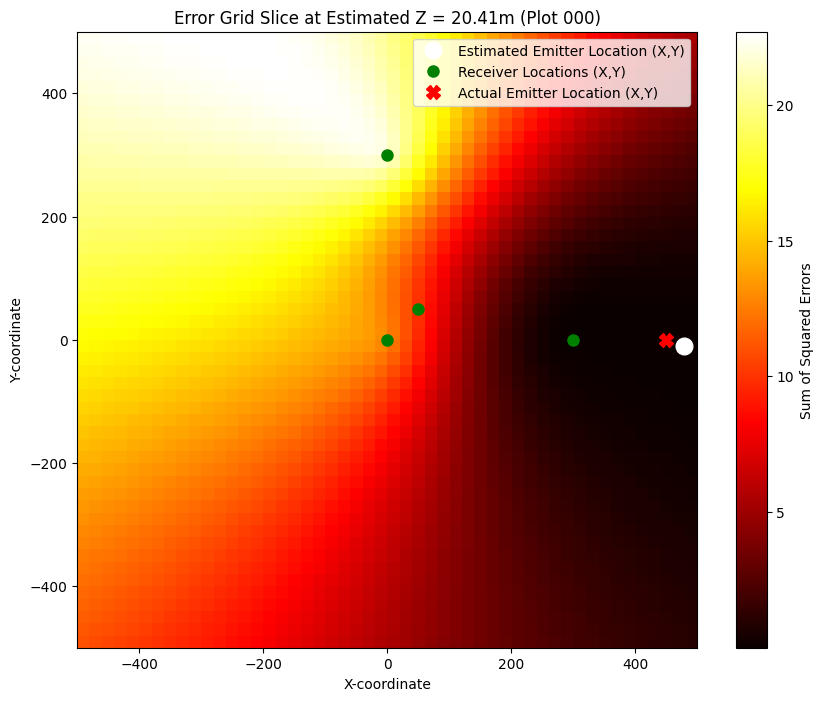

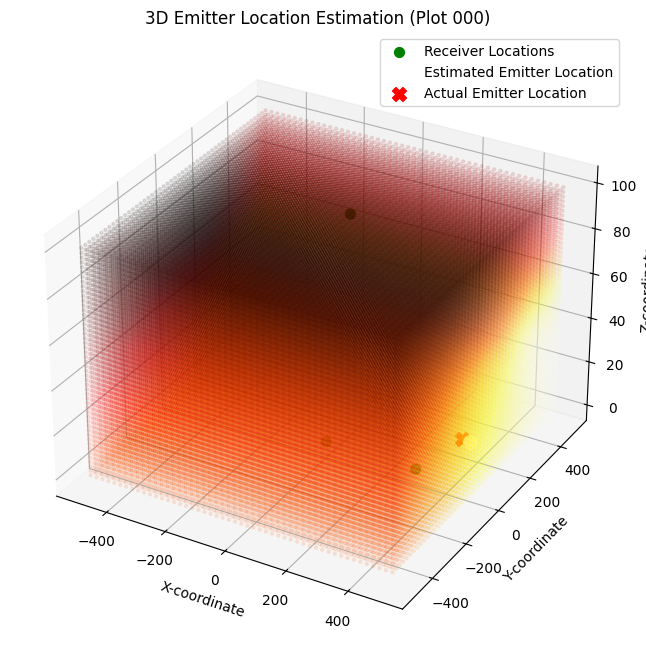

Estimated Emitter Location (3D): (np.float64(479.59183673469386), np.float64(-10.204081632653072), np.float64(20.408163265306122))
Simulating for emitter position 2/100: [449.09400441  28.54076385  20.        ]
Distance between source and receivers:
  Receiver 1: 450.44 meters
  Receiver 2: 153.11 meters
  Receiver 3: 525.14 meters
  Receiver 4: 407.60 meters
Speed of sound at 20°C: 343.42 m/s
Time of travel:
  Receiver 1: 1.3116 seconds
  Receiver 2: 0.4458 seconds
  Receiver 3: 1.5292 seconds
  Receiver 4: 1.1869 seconds
Signal departure time: 2025-08-31 07:53:51.068387
Estimated signal arrival time:
  Receiver 1: 2025-08-31 07:53:52.380029
  Receiver 2: 2025-08-31 07:53:51.514235
  Receiver 3: 2025-08-31 07:53:52.597545
  Receiver 4: 2025-08-31 07:53:52.255267
Successfully loaded audio file with sample rate: 44100 Hz
Audio data shape: (441001,)
Saved attenuated and delayed audio for Receiver 1 to 'attenuated_delayed_audio_receiver_1.wav'
Saved attenuated and delayed audio for Receiv

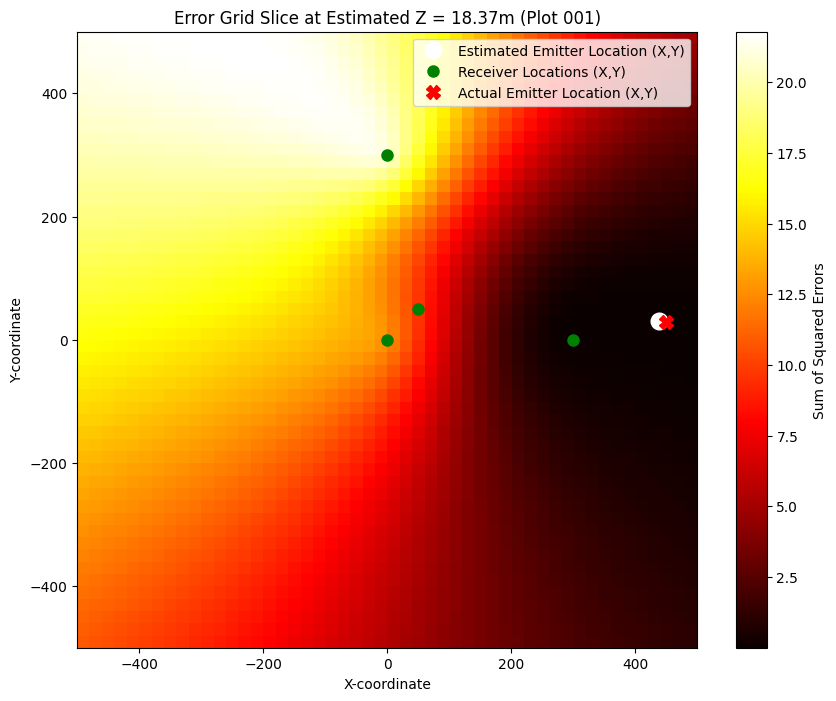

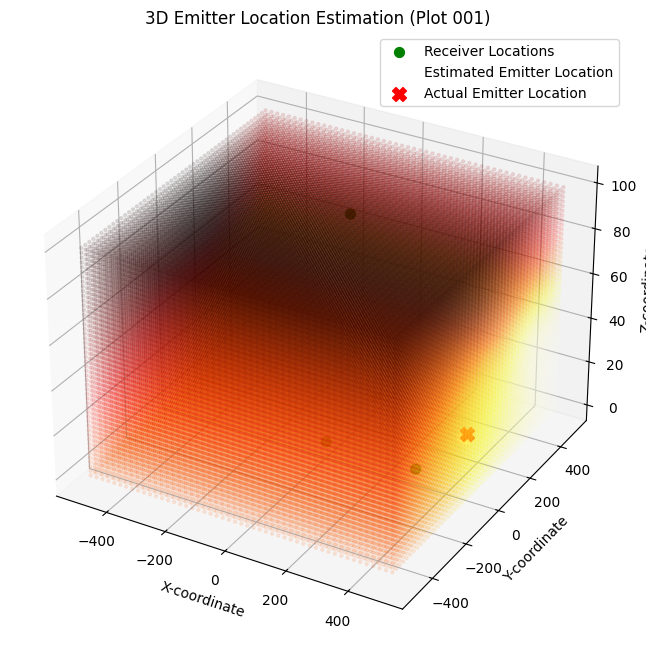

Estimated Emitter Location (3D): (np.float64(438.77551020408157), np.float64(30.612244897959158), np.float64(18.367346938775512))
Simulating for emitter position 3/100: [446.37966577  56.96660411  20.        ]
Distance between source and receivers:
  Receiver 1: 450.44 meters
  Receiver 2: 158.34 meters
  Receiver 3: 508.65 meters
  Receiver 4: 404.43 meters
Speed of sound at 20°C: 343.42 m/s
Time of travel:
  Receiver 1: 1.3116 seconds
  Receiver 2: 0.4611 seconds
  Receiver 3: 1.4811 seconds
  Receiver 4: 1.1777 seconds
Signal departure time: 2025-08-31 07:54:19.351674
Estimated signal arrival time:
  Receiver 1: 2025-08-31 07:54:20.663316
  Receiver 2: 2025-08-31 07:54:19.812748
  Receiver 3: 2025-08-31 07:54:20.832791
  Receiver 4: 2025-08-31 07:54:20.529334
Successfully loaded audio file with sample rate: 44100 Hz
Audio data shape: (441001,)
Saved attenuated and delayed audio for Receiver 1 to 'attenuated_delayed_audio_receiver_1.wav'
Saved attenuated and delayed audio for Receive

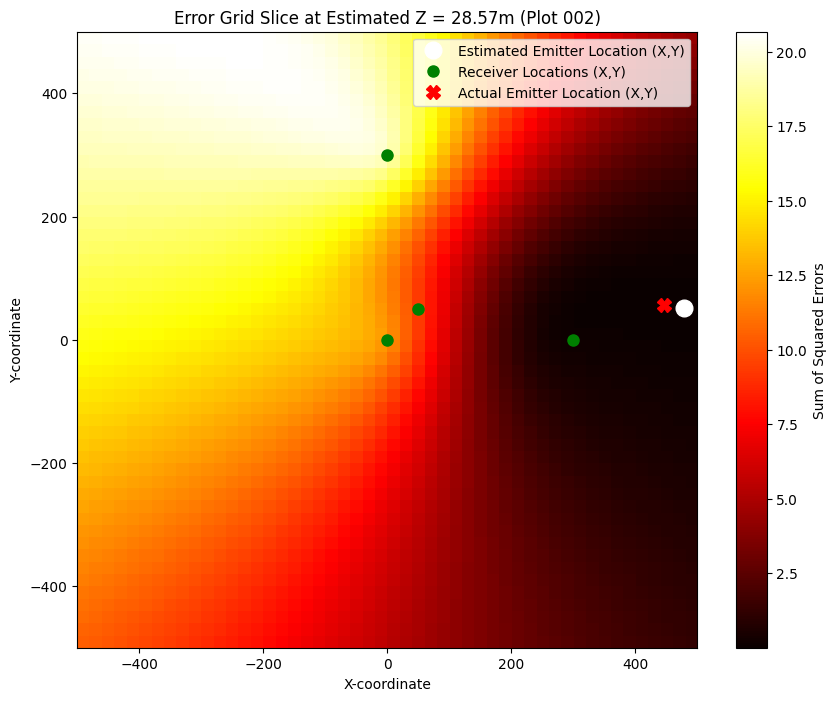

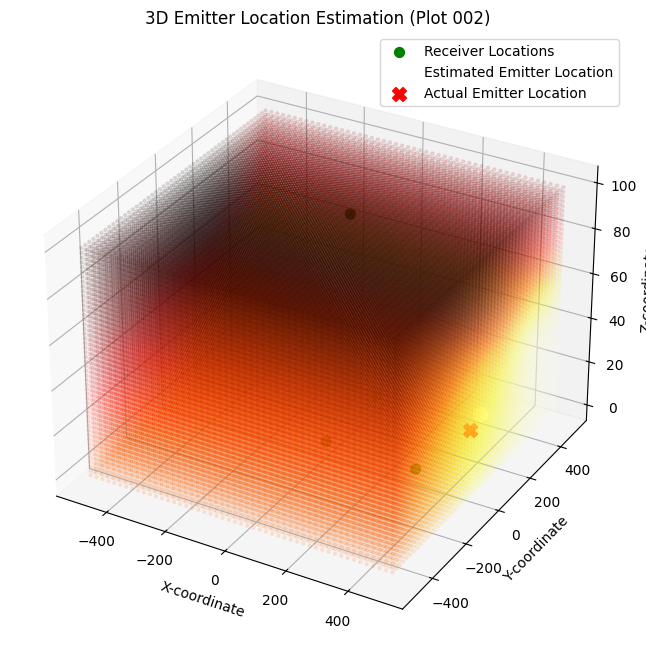

Estimated Emitter Location (3D): (np.float64(479.59183673469386), np.float64(51.0204081632653), np.float64(28.571428571428573))
Simulating for emitter position 4/100: [441.86791377  85.16305996  20.        ]
Distance between source and receivers:
  Receiver 1: 450.44 meters
  Receiver 2: 166.67 meters
  Receiver 3: 491.73 meters
  Receiver 4: 401.49 meters
Speed of sound at 20°C: 343.42 m/s
Time of travel:
  Receiver 1: 1.3116 seconds
  Receiver 2: 0.4853 seconds
  Receiver 3: 1.4319 seconds
  Receiver 4: 1.1691 seconds
Signal departure time: 2025-08-31 07:54:47.679759
Estimated signal arrival time:
  Receiver 1: 2025-08-31 07:54:48.991401
  Receiver 2: 2025-08-31 07:54:48.165086
  Receiver 3: 2025-08-31 07:54:49.111632
  Receiver 4: 2025-08-31 07:54:48.848862
Successfully loaded audio file with sample rate: 44100 Hz
Audio data shape: (441001,)
Saved attenuated and delayed audio for Receiver 1 to 'attenuated_delayed_audio_receiver_1.wav'
Saved attenuated and delayed audio for Receiver 

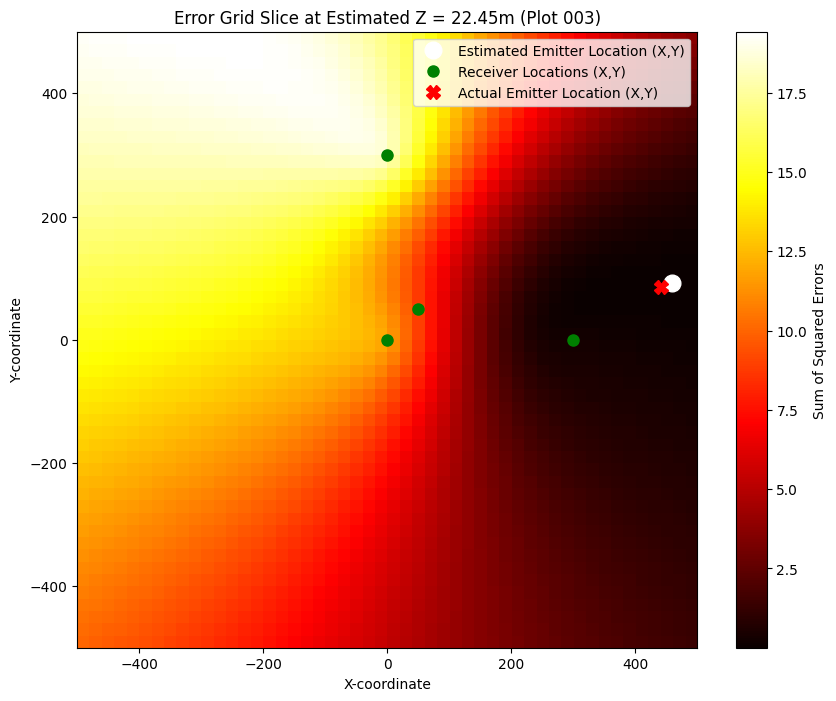

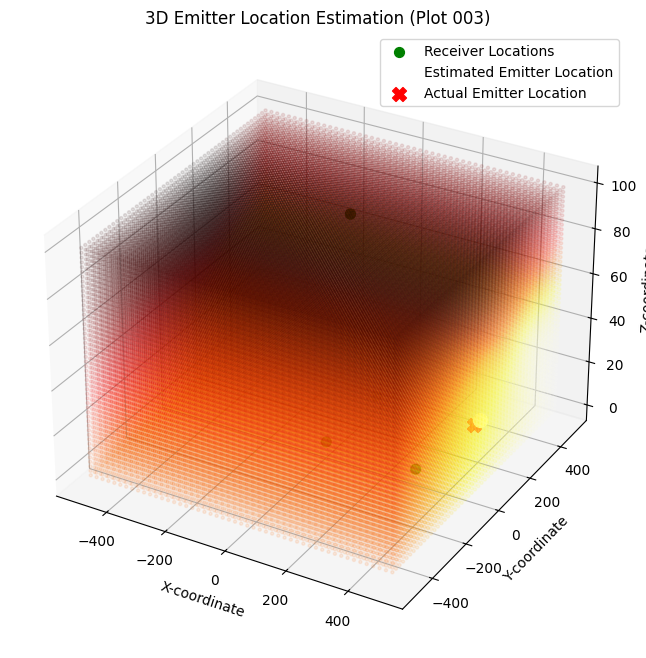

Estimated Emitter Location (3D): (np.float64(459.1836734693877), np.float64(91.83673469387759), np.float64(22.448979591836736))
Simulating for emitter position 5/100: [435.57691563 113.01659423  20.        ]
Distance between source and receivers:
  Receiver 1: 450.44 meters
  Receiver 2: 177.63 meters
  Receiver 3: 474.44 meters
  Receiver 4: 398.80 meters
Speed of sound at 20°C: 343.42 m/s
Time of travel:
  Receiver 1: 1.3116 seconds
  Receiver 2: 0.5173 seconds
  Receiver 3: 1.3815 seconds
  Receiver 4: 1.1613 seconds
Signal departure time: 2025-08-31 07:55:16.704587
Estimated signal arrival time:
  Receiver 1: 2025-08-31 07:55:18.016229
  Receiver 2: 2025-08-31 07:55:17.221837
  Receiver 3: 2025-08-31 07:55:18.086092
  Receiver 4: 2025-08-31 07:55:17.865844
Successfully loaded audio file with sample rate: 44100 Hz
Audio data shape: (441001,)
Saved attenuated and delayed audio for Receiver 1 to 'attenuated_delayed_audio_receiver_1.wav'
Saved attenuated and delayed audio for Receiver 

KeyboardInterrupt: 

In [10]:
# Step 1: Update receiver locations to 3D and add the fourth receiver
receiver_locations = [(0, 0, 0), (300, 0, 0), (0, 300, 0), (50, 50, 100)]

#avg_result = np.mean([result.x for result in results], axis=0)
# The 'result' variable might not be defined at this point if the cell hasn't been run after the locate_emitter function is defined.
# We can remove or comment out this line if it causes an error.
# print("Estimated emitter location:", result)

your_audio_file = 'DRONE_001_L.wav' # Replace with your audio file

simulated_arrival_times = []
estimated_locations = []

# Step 2-5: Iterate through the route, simulate, get time shifts, estimate location, and save plots
# Ensure emitter_route is defined before this loop
# Example: emitter_route = generate_circular_route(center=(0,0), radius=450, num_points=100, z_height=20)

# Let's limit the number of points for simulation to avoid excessive runtime
for i, emitter_location in enumerate(emitter_route[:30]): # Processing first 30 points as an example
    print(f"Simulating for emitter position {i+1}/{len(emitter_route)}: {emitter_location}")

    # Simulate arrival times at receivers (now handles 3D locations)
    # Note: simulation_arrival_sound also saves attenuated audio files for each receiver
    arrival_times = simulation_arrival_sound(emitter_location, receiver_locations, your_audio_file, temperature_celsius=20)

    # Get time shifts from attenuated audio files (now handles 4 receivers)
    arrivals = get_time_shifts()

    if arrivals is not None:
        # detection_times are the time differences relative to the first receiver
        # Assuming the first receiver's detection time is 0 relative to itself
        detection_times = arrivals # get_time_shifts now returns the time shifts relative to the first receiver

        speed = speed_of_sound(20)  # Replace with the actual speed of sound

        # Locate the emitter using the estimated time differences (now handles 3D)
        result = locate_emitter(receiver_locations, detection_times, speed, plot_counter=i, actual_location=emitter_location) # Pass the loop index as plot_counter and actual location
        estimated_locations.append(result)
    else:
        print(f"Could not get time shifts for position {i+1}. Skipping location estimation.")


print("\nEstimated emitter locations for the processed points in the route:")
# Print only the first few to avoid excessive output
for i, location in enumerate(estimated_locations[:5]):
    print(f"Position {i+1}: {location}")

In [11]:
from PIL import Image
import glob
import os

# Directory containing the saved 3D scatter plots
output_dir = "emitter_heatmaps"

# Get the list of 3D scatter plot image files, sorted by filename
image_files = sorted(glob.glob(os.path.join(output_dir, "scatter_3d_*.jpg")))

if not image_files:
    print(f"No 3D scatter plot image files found in '{output_dir}'. Please ensure the 3D plots were saved correctly.")
else:
    # Read the first image to get the size and create the list of images
    img, *imgs = [Image.open(f) for f in image_files]

    # Save the images as a GIF
    gif_path = "emitter_3d_animation.gif" # Changed filename to avoid overwriting the 2D animation
    img.save(gif_path, save_all=True, append_images=imgs, duration=200, loop=0)

    print(f"3D GIF animation saved to '{gif_path}'")

3D GIF animation saved to 'emitter_3d_animation.gif'


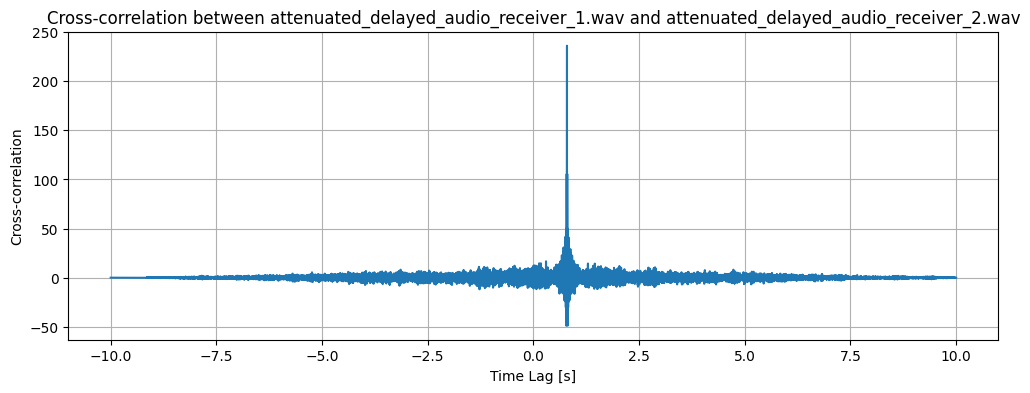

Estimated time shift: 0.794376 seconds


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import correlate
import os

# List of attenuated audio file paths (choose two to cross-correlate)
file_path_1 = 'attenuated_delayed_audio_receiver_1.wav'
file_path_2 = 'attenuated_delayed_audio_receiver_2.wav'

try:
    # Read the audio data from the files
    sample_rate_1, audio_data_1 = wavfile.read(file_path_1)
    sample_rate_2, audio_data_2 = wavfile.read(file_path_2)

    # Ensure sample rates are the same
    if sample_rate_1 != sample_rate_2:
        print("Error: The audio files have different sample rates.")
    else:
        sample_rate = sample_rate_1

        # If stereo, use only one channel
        if audio_data_1.ndim > 1:
            audio_data_1 = audio_data_1[:, 0]
        if audio_data_2.ndim > 1:
            audio_data_2 = audio_data_2[:, 0]

        # Convert to float for cross-correlation
        audio_data_1 = audio_data_1.astype(np.float64)
        audio_data_2 = audio_data_2.astype(np.float64)

        # Perform cross-correlation
        correlation = correlate(audio_data_1, audio_data_2, mode='full')

        # Create a time vector for the cross-correlation result
        # The lags array has length N + M - 1, where N and M are the lengths of the input signals
        lags = np.arange(-(audio_data_1.shape[0] - 1), audio_data_2.shape[0])
        time_lags = lags / sample_rate

        # Plot the cross-correlation
        plt.figure(figsize=(12, 4))
        plt.plot(time_lags, correlation)
        plt.xlabel("Time Lag [s]")
        plt.ylabel("Cross-correlation")
        plt.title(f"Cross-correlation between {file_path_1} and {file_path_2}")
        plt.grid(True)

        # Save the cross-correlation plot
        output_dir = "audio_plots"
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, "cross_correlation.jpg"))

        plt.show()

        # Find the lag corresponding to the peak of the cross-correlation
        peak_index = np.argmax(correlation)
        peak_lag = lags[peak_index]
        time_shift = peak_lag / sample_rate

        print(f"Estimated time shift: {time_shift:.6f} seconds")


except FileNotFoundError:
    print("Error: One or both of the audio files were not found.")
except Exception as e:
    print(f"An error occurred: {e}")

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import os
import matplotlib.cm as cm
import plotly.graph_objects as go


def locate_emitter_3d(receiver_locations, detection_times, speed_of_sound_mps, plot_counter=0, actual_location=None):
    """
    Estimates the location of a signal emitter in 3D space using TDOA by
    performing a grid search with parallel processing and saves a 2D slice
    of the error grid and a 3D scatter plot/heatmap (Plotly).
    """
    receiver_locations = np.array(receiver_locations)

    def calculate_error(emitter_location, receiver_locations, detection_times, speed_of_sound_mps):
        """Calculates the sum of squared errors for a given emitter location in 3D."""
        x, y, z = emitter_location
        errors = []
        for i in range(len(receiver_locations)):
            receiver_x, receiver_y, receiver_z = receiver_locations[i]
            distance = np.sqrt((x - receiver_x)**2 + (y - receiver_y)**2 + (z - receiver_z)**2)
            expected_time_diffs = [
                (np.sqrt((x - rx)**2 + (y - ry)**2 + (z - rz)**2) - distance) / speed_of_sound_mps
                for rx, ry, rz in receiver_locations
            ]
            actual_time_diffs = [(dt - detection_times[i]) for dt in detection_times]
            for j in range(len(actual_time_diffs)):
                errors.append((actual_time_diffs[j] - expected_time_diffs[j])**2)
        return np.sum(errors)

    # --- Grid search ---
    grid_size = 30  # reduce for performance in Plotly
    x_range = np.linspace(-500, 500, grid_size)
    y_range = np.linspace(-500, 500, grid_size)
    z_range = np.linspace(0, 100, grid_size)
    coords = [(x, y, z) for z in z_range for y in y_range for x in x_range]

    errors = Parallel(n_jobs=-1)(
        delayed(calculate_error)(coord, receiver_locations, detection_times, speed_of_sound_mps)
        for coord in coords
    )
    error_grid = np.array(errors).reshape((grid_size, grid_size, grid_size))

    # --- Best emitter ---
    min_error_index = np.argmin(error_grid)
    min_error_z, min_error_y, min_error_x = np.unravel_index(min_error_index, error_grid.shape)
    best_emitter_location = (x_range[min_error_x], y_range[min_error_y], z_range[min_error_z])

    # --- 2D Matplotlib slice ---
    estimated_z_index = np.argmin(np.abs(z_range - best_emitter_location[2]))
    error_slice = error_grid[estimated_z_index, :, :]

    plt.figure(figsize=(10, 8))
    plt.imshow(error_slice, extent=[x_range.min(), x_range.max(), y_range.min(), y_range.max()],
               origin='lower', cmap='hot', aspect='auto')
    plt.colorbar(label="Sum of Squared Errors")
    plt.title(f"Error Grid Slice at Estimated Z = {z_range[estimated_z_index]:.2f}m (Plot {plot_counter:03d})")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")

    plt.plot(best_emitter_location[0], best_emitter_location[1], 'wo', markersize=12, label='Estimated Emitter (X,Y)')
    plt.plot(receiver_locations[:, 0], receiver_locations[:, 1], 'go', markersize=8, label='Receivers (X,Y)')
    if actual_location is not None:
        plt.plot(actual_location[0], actual_location[1], 'rX', markersize=10, label='Actual Emitter (X,Y)')
    plt.legend()

    output_dir = "emitter_heatmaps"
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, f"heatmap_slice_{plot_counter:03d}.jpg"))
    plt.show()

    # --- 3D Plotly visualization ---
    X, Y, Z = np.meshgrid(x_range, y_range, z_range, indexing="ij")
    x_flat, y_flat, z_flat, error_flat = X.flatten(), Y.flatten(), Z.flatten(), error_grid.flatten()

    fig = go.Figure()

    # Error heat cloud
    fig.add_trace(go.Scatter3d(
        x=x_flat, y=y_flat, z=z_flat,
        mode="markers",
        marker=dict(
            size=2,
            color=error_flat,
            colorscale="Hot",
            opacity=0.2,
            colorbar=dict(title="Error")
        ),
        name="Error cloud"
    ))

    # Receivers
    fig.add_trace(go.Scatter3d(
        x=receiver_locations[:, 0], y=receiver_locations[:, 1], z=receiver_locations[:, 2],
        mode="markers",
        marker=dict(size=6, color="green", symbol="circle"),
        name="Receivers"
    ))

    # Estimated emitter
    fig.add_trace(go.Scatter3d(
        x=[best_emitter_location[0]], y=[best_emitter_location[1]], z=[best_emitter_location[2]],
        mode="markers",
        marker=dict(size=10, color="white", symbol="circle"),
        name="Estimated Emitter"
    ))

    # Actual emitter (if given)
    if actual_location is not None:
        fig.add_trace(go.Scatter3d(
            x=[actual_location[0]], y=[actual_location[1]], z=[actual_location[2]],
            mode="markers",
            marker=dict(size=10, color="red", symbol="x"),
            name="Actual Emitter"
        ))

    fig.update_layout(
        title=f"3D Emitter Location Estimation (Plot {plot_counter:03d})",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z"
        )
    )

    # Save interactive HTML
    fig.write_html(os.path.join(output_dir, f"scatter3d_{plot_counter:03d}.html"))
    fig.show()

    print(f"Estimated Emitter Location (3D): {best_emitter_location}")
    return best_emitter_location


Simulating for emitter position 1/2: [450, 0, 20]
Distance between source and receivers:
  Receiver 1: 450.44 meters
  Receiver 2: 151.33 meters
  Receiver 3: 541.20 meters
  Receiver 4: 410.97 meters
Speed of sound at 20°C: 343.42 m/s
Time of travel:
  Receiver 1: 1.3116 seconds
  Receiver 2: 0.4406 seconds
  Receiver 3: 1.5759 seconds
  Receiver 4: 1.1967 seconds
Signal departure time: 2025-08-31 07:56:43.258294
Estimated signal arrival time:
  Receiver 1: 2025-08-31 07:56:44.569936
  Receiver 2: 2025-08-31 07:56:43.698942
  Receiver 3: 2025-08-31 07:56:44.834214
  Receiver 4: 2025-08-31 07:56:44.455005
Successfully loaded audio file with sample rate: 44100 Hz
Audio data shape: (441001,)
Saved attenuated and delayed audio for Receiver 1 to 'attenuated_delayed_audio_receiver_1.wav'
Saved attenuated and delayed audio for Receiver 2 to 'attenuated_delayed_audio_receiver_2.wav'
Saved attenuated and delayed audio for Receiver 3 to 'attenuated_delayed_audio_receiver_3.wav'
Saved attenuated

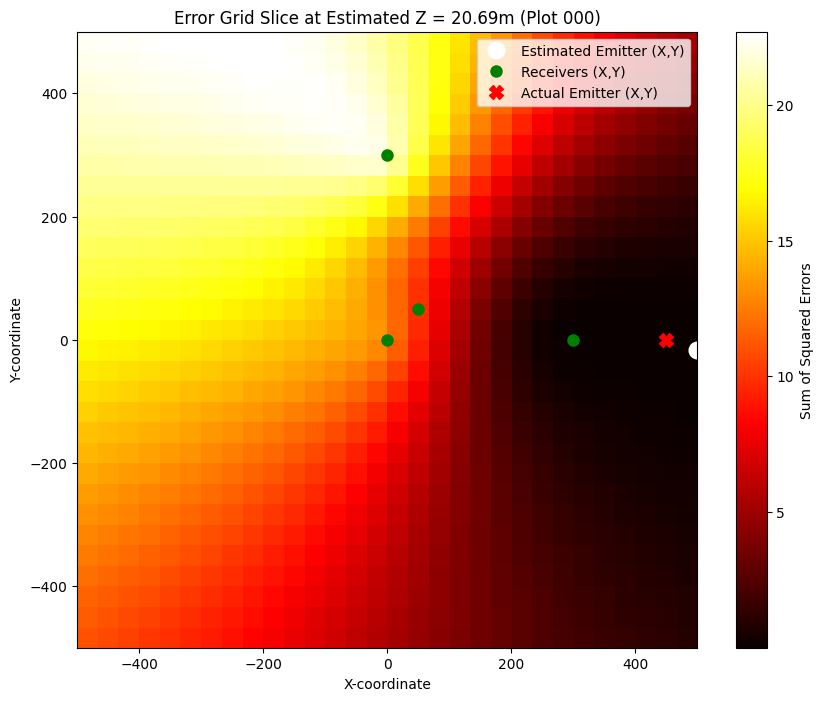

Estimated Emitter Location (3D): (np.float64(500.0), np.float64(-17.24137931034477), np.float64(20.689655172413794))
Simulating for emitter position 2/2: [400, 20, 100]
Distance between source and receivers:
  Receiver 1: 412.80 meters
  Receiver 2: 142.83 meters
  Receiver 3: 498.40 meters
  Receiver 4: 351.28 meters
Speed of sound at 20°C: 343.42 m/s
Time of travel:
  Receiver 1: 1.2020 seconds
  Receiver 2: 0.4159 seconds
  Receiver 3: 1.4513 seconds
  Receiver 4: 1.0229 seconds
Signal departure time: 2025-08-31 07:56:46.847390
Estimated signal arrival time:
  Receiver 1: 2025-08-31 07:56:48.049403
  Receiver 2: 2025-08-31 07:56:47.263291
  Receiver 3: 2025-08-31 07:56:48.298667
  Receiver 4: 2025-08-31 07:56:47.870287
Successfully loaded audio file with sample rate: 44100 Hz
Audio data shape: (441001,)
Saved attenuated and delayed audio for Receiver 1 to 'attenuated_delayed_audio_receiver_1.wav'
Saved attenuated and delayed audio for Receiver 2 to 'attenuated_delayed_audio_receiver

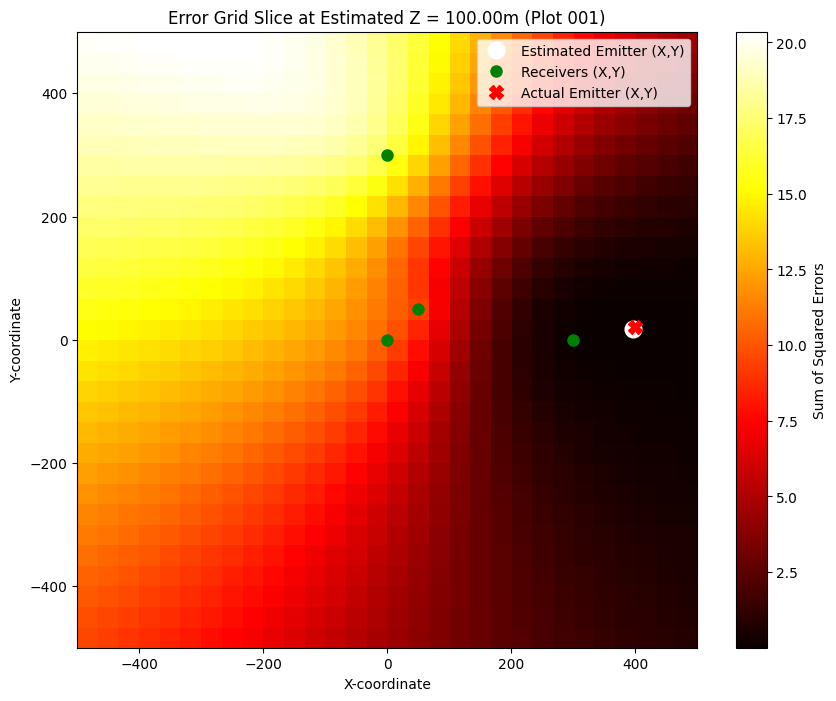

Estimated Emitter Location (3D): (np.float64(396.55172413793116), np.float64(17.241379310344882), np.float64(100.0))

Estimated emitter locations for the processed points in the route:
Position 1: (np.float64(500.0), np.float64(-17.24137931034477), np.float64(20.689655172413794))
Position 2: (np.float64(396.55172413793116), np.float64(17.241379310344882), np.float64(100.0))


In [16]:
# Step 1: Update receiver locations to 3D and add the fourth receiver
receiver_locations = [(0, 0, 0), (300, 0, 0), (0, 300, 0), (50, 50, 100)]

#avg_result = np.mean([result.x for result in results], axis=0)
# The 'result' variable might not be defined at this point if the cell hasn't been run after the locate_emitter function is defined.
# We can remove or comment out this line if it causes an error.
# print("Estimated emitter location:", result)

your_audio_file = 'DRONE_001_L.wav' # Replace with your audio file

simulated_arrival_times = []
estimated_locations = []

# Step 2-5: Iterate through the route, simulate, get time shifts, estimate location, and save plots
# Ensure emitter_route is defined before this loop
# Example: emitter_route = generate_circular_route(center=(0,0), radius=450, num_points=100, z_height=20)
emitter_route=[[450, 0, 20], [400, 20, 100]]
# Let's limit the number of points for simulation to avoid excessive runtime
for i, emitter_location in enumerate(emitter_route): # Processing first 30 points as an example
    print(f"Simulating for emitter position {i+1}/{len(emitter_route)}: {emitter_location}")

    # Simulate arrival times at receivers (now handles 3D locations)
    # Note: simulation_arrival_sound also saves attenuated audio files for each receiver
    arrival_times = simulation_arrival_sound(emitter_location, receiver_locations, your_audio_file, temperature_celsius=20)

    # Get time shifts from attenuated audio files (now handles 4 receivers)
    arrivals = get_time_shifts()

    if arrivals is not None:
        # detection_times are the time differences relative to the first receiver
        # Assuming the first receiver's detection time is 0 relative to itself
        detection_times = arrivals # get_time_shifts now returns the time shifts relative to the first receiver

        speed = speed_of_sound(20)  # Replace with the actual speed of sound

        # Locate the emitter using the estimated time differences (now handles 3D)
        result = locate_emitter_3d(receiver_locations, detection_times, speed, plot_counter=i, actual_location=emitter_location) # Pass the loop index as plot_counter and actual location
        estimated_locations.append(result)
    else:
        print(f"Could not get time shifts for position {i+1}. Skipping location estimation.")


print("\nEstimated emitter locations for the processed points in the route:")
# Print only the first few to avoid excessive output
for i, location in enumerate(estimated_locations[:5]):
    print(f"Position {i+1}: {location}")